<a href="https://colab.research.google.com/github/CristianRiquelmeF/NLP-aplicado-a-Clasificacion-de-Notas-Clinicas/blob/main/M8Final_CristianRiquelme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Nombre: Cristian Riquelme



> Clasificación de notas clínicas para detección temprana de afecciones, con enfoque ético y mitigación de sesgos

**Objetivo:** Desarrollar un sistema de NLP capaz de clasificar textos médicos (notas clínicas, síntomas, diagnósticos) según su gravedad clínica (leve/moderado/severo) integrando buenas prácticas de preprocesamiento, evaluación y mitigación de sesgos lingüísticos y sociales.


In [ ]:
!pip install gensim #para W2V

In [ ]:
# Carga de librerías
import re
import string
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Recursos de NLTK
warnings.filterwarnings("ignore")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**CARGA DE DATASET CON EVALUACIONES MÉDICAS**

- El set original para la actividad contenía 200 evaluaciones, se decidió generar más con ayuda de IA hasta la cantidad de 455 para crear un modelo basado en más datos. Se crearon con el criterio de variedad lingüistica, ambigüedad de términos y correlaciones rotas (contexto completo necesario), esto con el fin de crear variedad y complejidad a los modelos.

In [ ]:
# Cargar el dataset desde el archivo CSV proporcionado
df = pd.read_csv('MLM8 - EVALUACIÓN MODULAR dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   texto_clinico  455 non-null    object
 1   edad           455 non-null    int64 
 2   genero         455 non-null    object
 3   afeccion       455 non-null    object
 4   gravedad       455 non-null    object
dtypes: int64(1), object(4)
memory usage: 17.9+ KB


In [ ]:
# Análisis exploratorio inicial
print("\nRevisión inicial")
print(f"Número total de registros: {len(df)}")
print(f"Número de variables: {df.shape[1]}")
print("\nDistribución de la gravedad:")
print(df['gravedad'].value_counts())
print("\nDistribución por género:")
print(df['genero'].value_counts())
print("\nDistribución de afecciones:")
print(df['afeccion'].value_counts())


Revisión inicial
Número total de registros: 455
Número de variables: 5

Distribución de la gravedad:
gravedad
moderado    200
severo      144
leve        111
Name: count, dtype: int64

Distribución por género:
genero
M    256
F    199
Name: count, dtype: int64

Distribución de afecciones:
afeccion
gastroenteritis               34
resfriado común               33
infarto agudo de miocardio    32
bronquitis                    32
hipertensión leve             31
diabetes tipo 2               30
asma                          28
migraña                       26
insuficiencia renal aguda     25
neumonía                      23
fractura de muñeca            22
dolor lumbar                  18
cefalea tensional             13
esguince de tobillo           13
dolor lumbar crónico          13
apendicitis aguda             13
ACV isquémico                 13
sepsis                        13
fractura expuesta             13
infección urinaria            10
crisis de ansiedad            10
neumoní

**GRÁFICA DE DISTRIBUCIÓN DE LAS VARIABLES**

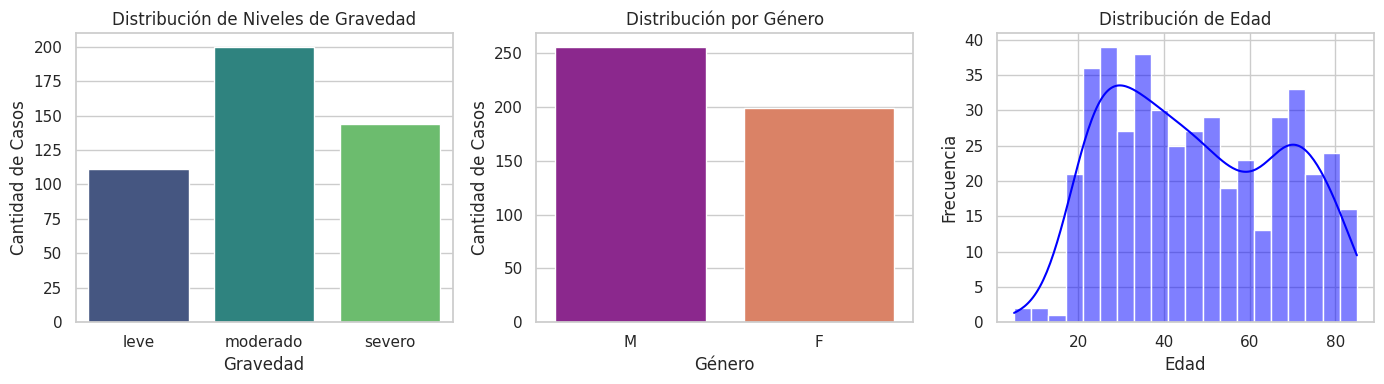

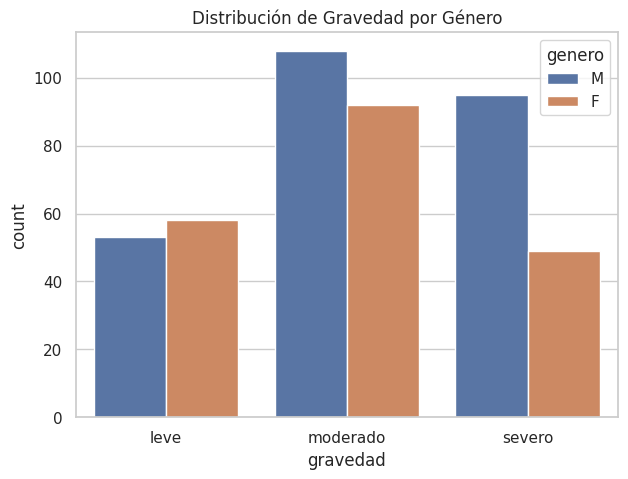

In [ ]:
# Configuración visual para los gráficos
sns.set_theme(style="whitegrid")

# Crear una figura para los gráficos
plt.figure(figsize=(14, 4))

# 1. Gráfico de distribución de la variable objetivo 'gravedad'
plt.subplot(1, 3, 1)
sns.countplot(x='gravedad', data=df, order=['leve', 'moderado', 'severo'], palette="viridis")
plt.title('Distribución de Niveles de Gravedad')
plt.xlabel('Gravedad')
plt.ylabel('Cantidad de Casos')

# 2. Gráfico de distribución por 'genero'
plt.subplot(1, 3, 2)
sns.countplot(x='genero', data=df, palette="plasma")
plt.title('Distribución por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad de Casos')

# 3. Gráfico de distribución de 'edad'
plt.subplot(1, 3, 3)
sns.histplot(df['edad'], kde=True, bins=20, color='blue')
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Análisis de la distribución de gravedad por género
plt.figure(figsize=(7, 5))
sns.countplot(x='gravedad', hue='genero', data=df, order=['leve', 'moderado', 'severo'])
plt.title('Distribución de Gravedad por Género')
plt.show()

**PREPROCESAMIENTO NLP**

In [ ]:
# Preprocesamiento de texto
stop_words = set(stopwords.words('spanish'))  # usar español
lemmatizer = SnowballStemmer('spanish')

def clean_text(text):
    if pd.isna(text):
        return ""
    # minusculas
    text = text.lower()
    # reemplazar urls, numeros y signos
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    # quitar puntuacion
    text = text.translate(str.maketrans("", "", string.punctuation))
    # normalizar espacios
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_and_lemmatize(text):
    # tokenizacion simple con nltk
    tokens = nltk.word_tokenize(text, language='spanish')
    # filtrar stopwords y tokens pequeños
    toks = [t for t in tokens if t not in stop_words and len(t) > 1]

    lemmas = [lemmatizer.stem(t) for t in toks]
    return " ".join(lemmas)

# Aplicar limpieza y tokenización/lemmatización
df['texto_limpio'] = df['texto_clinico'].astype(str).apply(clean_text)
df['texto_proc'] = df['texto_limpio'].apply(tokenize_and_lemmatize)

print("Ejemplos procesados:")
print(df[['texto_clinico', 'texto_proc']].head(5))

Ejemplos procesados:
                                       texto_clinico  \
0  El paciente presenta síntomas leves como dolor...   
1  Consulta por hipertensión leve sin signos de a...   
2  Evolución rápida del cuadro clínico, compatibl...   
3  El paciente presenta síntomas leves como tos y...   
4  El cuadro clínico indica asma, con síntomas co...   

                                          texto_proc  
0  pacient present sintom lev dolor cabez dificul...  
1                consult hipertension lev sign alarm  
2  evolu rap cuadr clinic compat infart agud mioc...  
3               pacient present sintom lev tos fatig  
4           cuadr clinic indic asma sintom tos fiebr  


In [ ]:
# Revisión DataFrame
df

,texto_clinico,edad,genero,afeccion,gravedad,texto_limpio,texto_proc
0,El paciente presenta síntomas leves como dolor...,43,M,resfriado común,leve,el paciente presenta síntomas leves como dolor...,pacient present sintom lev dolor cabez dificul...
1,Consulta por hipertensión leve sin signos de a...,34,F,hipertensión leve,leve,consulta por hipertensión leve sin signos de a...,consult hipertension lev sign alarm
2,"Evolución rápida del cuadro clínico, compatibl...",34,M,infarto agudo de miocardio,severo,evolución rápida del cuadro clínico compatible...,evolu rap cuadr clinic compat infart agud mioc...
3,El paciente presenta síntomas leves como tos y...,58,M,gastroenteritis,leve,el paciente presenta síntomas leves como tos y...,pacient present sintom lev tos fatig
4,"El cuadro clínico indica asma, con síntomas co...",45,M,asma,moderado,el cuadro clínico indica asma con síntomas com...,cuadr clinic indic asma sintom tos fiebr
...,...,...,...,...,...,...,...
450,Prostatitis aguda. Causa de infección urinaria...,33,M,infección urinaria,moderado,prostatitis aguda causa de infección urinaria ...,prostatitis agud caus infeccion urinari varon jov
451,Fractura en tallo verde en la muñeca de un niño.,10,M,fractura de muñeca,moderado,fractura en tallo verde en la muñeca de un niño,fractur tall verd muñec niñ
452,Ansiedad social. Miedo intenso a situaciones s...,26,F,crisis de ansiedad,moderado,ansiedad social miedo intenso a situaciones so...,ansied social mied intens situacion social
453,Síndrome de dificultad respiratoria del adulto...,75,M,neumonía grave,severo,síndrome de dificultad respiratoria del adulto...,sindrom dificult respiratori adult sdra neumon...


**División inicial en entrenamiento y prueba (estratificada)**

In [ ]:
# Dividir el texto preprocesado y las etiquetas
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['texto_proc'],
    df['gravedad'],
    test_size=0.3,
    random_state=40,
    stratify=df['gravedad'] # Usar stratify para mantener la proporción de clases
)

**REPRESENTACIONES TF-IDF Y WORD EMBEDDING**

 - TF-IDF: Esta técnica convierte el texto en vectores numéricos, asignando un peso a cada palabra según su frecuencia en un documento y su rareza en todo el corpus.

In [ ]:
# Vectorización TF-IDF
# Ajustar el vectorizador SÓLO en los datos de entrenamiento ---
vectorizer_tfidf = TfidfVectorizer(max_features=1000)

# Ajustamos Y transformamos el conjunto de entrenamiento
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_text)
X_test_tfidf = vectorizer_tfidf.transform(X_test_text)

# Mostrar las dimensiones de la matriz resultante
print("Dimensiones de la matriz TF-IDF:", X_train_tfidf.shape)

Dimensiones de la matriz TF-IDF: (318, 676)


- Word2Vec: Su objetivo principal es convertir palabras en vectores numéricos de tal forma que las palabras con significados similares tengan vectores cercanos en el espacio vectorial.

In [ ]:
# Word2Vec (gensim)
from gensim.models import Word2Vec
sentences_train = [text.split() for text in X_train_text]
w2v_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

# Función para crear vectores de documento
def document_vector(doc_tokens, model):
    doc_vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    if not doc_vectors:
        return np.zeros(model.vector_size)
    return np.mean(doc_vectors, axis=0)

# Crear los vectores de documento para ambos conjuntos
X_train_w2v = np.array([document_vector(text.split(), w2v_model) for text in X_train_text])
X_test_w2v = np.array([document_vector(text.split(), w2v_model) for text in X_test_text])


In [ ]:
# Codificación de la variable objetivo

le = LabelEncoder()
y = le.fit_transform(df['gravedad'])  # 0/1/2 mapping: leve/moderado/severo
label_names = le.classes_.tolist()
print("Labels:", label_names)

Labels: ['leve', 'moderado', 'severo']


# **MODELOS DE CLASIFICACIÓN**

- Random Forest + Word2Vec


 Resultados del Modelo: Random Forest + Word2Vec 
              precision    recall  f1-score   support

        leve       1.00      0.85      0.92        34
    moderado       0.78      0.95      0.86        60
      severo       0.91      0.74      0.82        43

    accuracy                           0.86       137
   macro avg       0.90      0.85      0.87       137
weighted avg       0.88      0.86      0.86       137



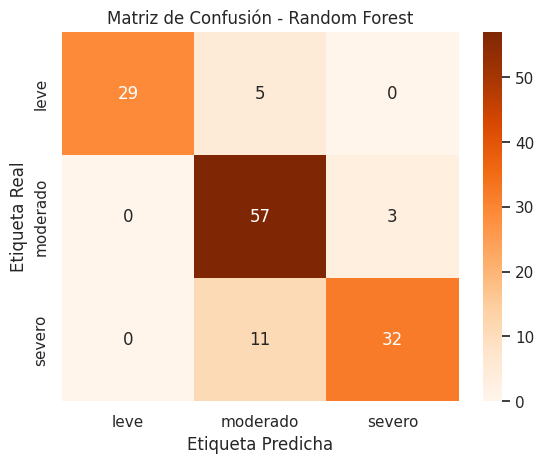

In [ ]:
# Entrenar el modelo
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train_w2v, y_train)

# Evaluar en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test_w2v)

print("\n Resultados del Modelo: Random Forest + Word2Vec ")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', xticklabels=['leve', 'moderado', 'severo'], yticklabels=['leve', 'moderado', 'severo'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

- SVM ligero + Word2Vec


--- LinearSVC (Word2Vec) ---
              precision    recall  f1-score   support

        leve       0.00      0.00      0.00        34
    moderado       0.44      1.00      0.61        60
      severo       0.00      0.00      0.00        43

    accuracy                           0.44       137
   macro avg       0.15      0.33      0.20       137
weighted avg       0.19      0.44      0.27       137



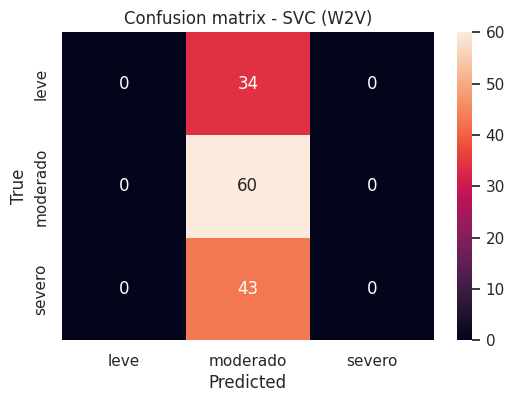

In [ ]:
from sklearn.svm import LinearSVC

# Entrenar el modelo
svc = LinearSVC(random_state=42, max_iter=100,
                class_weight='balanced', dual=False)
svc.fit(X_train_w2v, y_train)

# Evaluar en el conjunto de prueba
y_pred_svc = svc.predict(X_test_w2v)

print("\n--- LinearSVC (Word2Vec) ---")
print(classification_report(y_test, y_pred_svc, target_names=label_names))

# Matriz de Confusión
cm2 = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion matrix - SVC (W2V)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

- Multinominal Naive Bayes + TF-IDF


 Multinomial Naive Bayes (TF-IDF) 
              precision    recall  f1-score   support

        leve       1.00      0.85      0.92        34
    moderado       0.81      0.93      0.87        60
      severo       0.90      0.81      0.85        43

    accuracy                           0.88       137
   macro avg       0.90      0.87      0.88       137
weighted avg       0.89      0.88      0.88       137



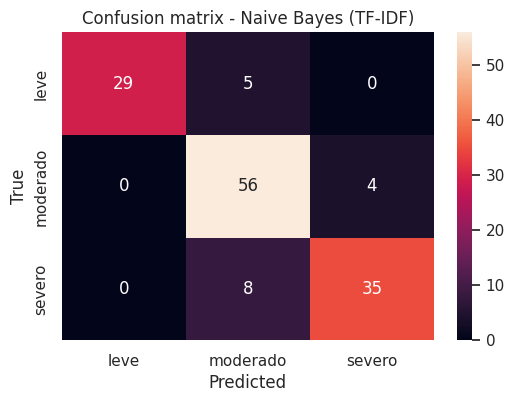

In [ ]:
# Entrenar el modelo
nb_model = MultinomialNB(
    alpha=2,
    fit_prior=True,
    class_prior=None)

nb_model.fit(X_train_tfidf, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluar el modelo en el conjunto de prueba
print("\n Multinomial Naive Bayes (TF-IDF) ")
print(classification_report(y_test, y_pred_nb, target_names=label_names))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion matrix - Naive Bayes (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **TRANSFORMER PRE-ENTRENADO 'BERT'**

In [ ]:
# PyTorch y Transformers para BERT
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

**PREPROCESAMIENTO**

- Se concatenarán las variables de entrada (texto clínico, género, edad, afección) en una única secuencia de texto. Esta estrategia permite que el modelo BERT utilice su mecanismo de atención para capturar las complejas interacciones y el contexto entre los datos demográficos y la descripción clínica.
BERT y otros modelos Transformers fueron diseñados para entender el lenguaje en su forma natural y rica, es por eso que se decide agregar información entre uniones para que se entiendan los números como edades, las letras como género y las afecciones observadas.

In [ ]:
# Crear la entrada de texto concatenada (usando el DataFrame original)
def crear_entrada_concatenada(row):
    return (f"TEXTO CLÍNICO: {row['texto_clinico']}. "
            f"AFECCIÓN DIAGNOSTICADA: {row['afeccion']}. "
            f"GÉNERO: {row['genero']}. "
            f"EDAD: {row['edad']}.")

df['input_bert'] = df.apply(crear_entrada_concatenada, axis=1)

# Dividir los datos para BERT
X_bert = df['input_bert'].tolist()
y_bert = df['gravedad'].tolist()
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_bert, y_bert, test_size=0.3, random_state=42, stratify=y_bert)

In [ ]:
# DataFrames de soporte para análisis estratificado
df_train_bert = pd.DataFrame({'text': X_train_bert, 'label': y_train_bert})
df_val_bert = pd.DataFrame({'text': X_val_bert, 'label': y_val_bert})

In [ ]:
# Visualización del texto despues de la concatenación e inclusión de texto referencial para el entendimiento de la semantica de BERT.
with pd.option_context('display.max_colwidth', None):
    print(df_train_bert['text'].head())

0                                   TEXTO CLÍNICO: Urgencia médica por dolor de cabeza, asociado a fractura de muñeca crítica.. AFECCIÓN DIAGNOSTICADA: fractura de muñeca. GÉNERO: M. EDAD: 47.
1                                            TEXTO CLÍNICO: Se observa un patrón consistente con dolor lumbar, requiere seguimiento.. AFECCIÓN DIAGNOSTICADA: dolor lumbar. GÉNERO: F. EDAD: 52.
2    TEXTO CLÍNICO: Refiere lumbago mecánico. Dolor aumenta al levantar objetos pesados. Se indican AINEs y reposo relativo.. AFECCIÓN DIAGNOSTICADA: dolor lumbar crónico. GÉNERO: M. EDAD: 44.
3                                                  TEXTO CLÍNICO: El paciente ha tenido 3 días de malestar, incluyendo dolor torácico.. AFECCIÓN DIAGNOSTICADA: bronquitis. GÉNERO: F. EDAD: 27.
4                                                    TEXTO CLÍNICO: Tos con expectoración herrumbrosa. Se sospecha neumonía neumocócica.. AFECCIÓN DIAGNOSTICADA: neumonía. GÉNERO: M. EDAD: 70.
Name: text, dtype: object


In [ ]:
# Codificación de Etiquetas
# El modelo necesita etiquetas numéricas (0, 1, 2) en lugar de texto ('leve', 'moderado', 'severo')
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_bert)
y_val_encoded = label_encoder.transform(y_val_bert)

**MODELO TRANSFORMER PRE-ENTRENADO**

- Se utilizará un modelo Transformer, específicamente el modelo de lenguaje de tipo BERT pre-entrenado **dccuchile/bert-base-spanish-wwm-cased**, por su alto rendimiento y profundo entendimiento del idioma español, lo cual es crucial para la terminología médica.  Es un modelo de lenguaje de última generación basado en la arquitectura BERT, pre-entrenado **específicamente para el idioma español**. Fue desarrollado por investigadores del Departamento de Ciencias de la Computación (DCC) de la Universidad de Chile.|

In [ ]:
# Cargar el Tokenizador y el Modelo
# Usamos dccuchile/bert-base-spanish-wwm-cased por ser un modelo especialista en español.
MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_encoder.classes_) # Se le indica que la clasificación es sobre 3 clases
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenización de los Datos
# Convertimos el texto en un formato que BERT pueda entender (input_ids, attention_mask)
train_encodings = tokenizer(X_train_bert, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val_bert, truncation=True, padding=True, max_length=128)

In [ ]:
# Creación de un Dataset Personalizado para PyTorch
# Creamos una clase para manejar los datos de forma eficiente durante el entrenamiento
class ClinicalNotesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Devuelve un diccionario con los tensores de PyTorch para un dato específico
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        # Devuelve el tamaño total del dataset
        return len(self.labels)

In [ ]:
# Instanciar los datasets de entrenamiento y validación
train_dataset = ClinicalNotesDataset(train_encodings, y_train_encoded)
val_dataset = ClinicalNotesDataset(val_encodings, y_val_encoded)

In [ ]:
# Configurar entrenamiento
# Aquí configuramos los hiperparámetros del fine-tuning
training_args = TrainingArguments(
    output_dir='./results',          # Directorio donde se guardarán los resultados y checkpoints
    num_train_epochs=4,              # Número de épocas de entrenamiento
    per_device_train_batch_size=16,  # Tamaño del lote por dispositivo (GPU/CPU) durante el entrenamiento
    per_device_eval_batch_size=16,   # Tamaño del lote para la evaluación
    warmup_steps=50,                 # Pasos de "calentamiento" para el optimizador
    weight_decay=0.01,               # Tasa de decaimiento de peso (regularización)
    logging_dir='./logs',            # Directorio para guardar los logs
    logging_steps=10,                # Frecuencia con la que se registran los logs
    eval_strategy="epoch",     # La evaluación se realiza al final de cada época
    save_strategy="epoch",           # El modelo se guarda al final de cada época
    load_best_model_at_end=True,     # Carga el mejor modelo encontrado durante el entrenamiento al final
    report_to="none"                 # Desactiva la integración con servicios de logging externos
)

In [ ]:
from transformers import EarlyStoppingCallback
# Creación del Entrenador
# Inclusión de callback 'EarlyStopping' para detener si la métrica de validación no mejora
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# Iniciar el Entrenamiento
# Esta llamada comienza el proceso de fine-tuning.
print("\nIniciando el fine-tuning de BERT...")
trainer.train()
print("Entrenamiento completado.")


Iniciando el fine-tuning de BERT...


Epoch,Training Loss,Validation Loss
1,0.001500,0.114290
2,0.000400,0.196925
3,0.000100,0.213750


Entrenamiento completado.


- El modelo se detiene antes de la cuarta epoca, demostrando la existencia de sobreajuste después del primer modelo y activando callback.

**Evaluación de modelo**


Reporte de Clasificación General (BERT) 
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        34
    moderado       1.00      0.97      0.98        60
      severo       0.96      1.00      0.98        43

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137

Generando Matriz de Confusión...


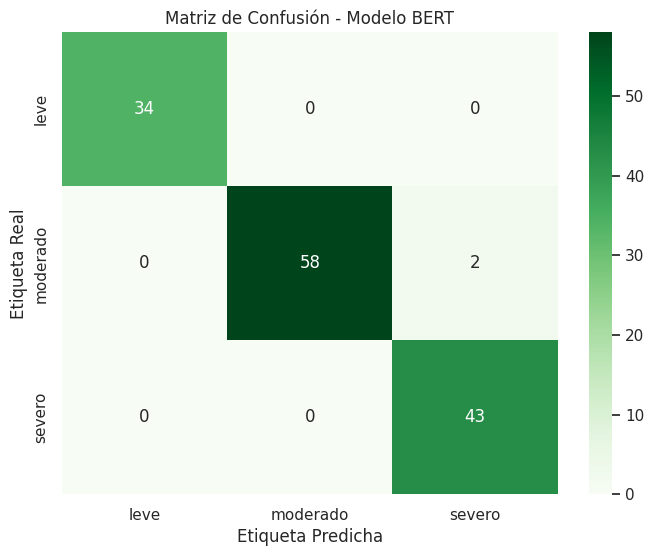

In [ ]:
# Realizar Predicciones
predictions_output = trainer.predict(val_dataset)

# Las predicciones del modelo son 'logits'. Necesitamos encontrar la clase con el logit más alto.
y_pred_encoded = np.argmax(predictions_output.predictions, axis=1)
y_true_encoded = y_val_encoded # Las etiquetas verdaderas que ya teníamos

# Decodificar las etiquetas para hacerlas legibles
# Convertimos los números (0, 1, 2) de vuelta a texto ('leve', 'moderado', 'severo')
y_true_labels = label_encoder.inverse_transform(y_true_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

# Reporte de Clasificación General
print("\nReporte de Clasificación General (BERT) ")
print(classification_report(y_true_labels, y_pred_labels, labels=['leve', 'moderado', 'severo']))

# Matriz de Confusión
print("Generando Matriz de Confusión...")
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=['leve', 'moderado', 'severo'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['leve', 'moderado', 'severo'],
            yticklabels=['leve', 'moderado', 'severo'])
plt.title('Matriz de Confusión - Modelo BERT')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

In [ ]:
# Crear un DataFrame con los resultados de la validación para un análisis fácil
df_val_results = pd.DataFrame({
    'texto_completo': X_val_bert,
    # Extraemos el género de la cadena de texto concatenada
    'genero': [row.split("GÉNERO: ")[1].split(".")[0] for row in X_val_bert],
    'gravedad_real': y_true_labels,
    'gravedad_pred': y_pred_labels})

In [ ]:
# Este DataFrame contiene: 'texto_completo', 'gravedad_real', 'gravedad_pred'

print("Muestra de Resultados de Clasificación del Modelo BERT")
# Configuramos pandas para mostrar el texto completo sin truncarlo
pd.set_option('display.max_colwidth', None)

# Creamos una columna para identificar fácilmente aciertos y errores
df_val_results['Resultado'] = df_val_results.apply(
    lambda row: "Acierto" if row['gravedad_real'] == row['gravedad_pred'] else "ERROR",
    axis=1)

# Seleccionamos y renombramos las columnas para una visualización clara
informe_resultados = df_val_results[[
    'gravedad_real',
    'gravedad_pred',
    'Resultado',
    'texto_completo'
]].rename(columns={
    'texto_completo': 'Texto de Entrada para el Modelo',
    'gravedad_real': 'Gravedad Real',
    'gravedad_pred': 'Predicción de BERT'})

# Usamos .to_string() para asegurar que se muestre todo el contenido de las celdas
print(informe_resultados.head(15).to_string())

# Adicional: Mostrar específicamente los casos donde el modelo se equivocó
print("\n\nCasos Específicos Donde el Modelo Cometió Errores")
errores = informe_resultados[informe_resultados['Resultado'] == "ERROR"]

if errores.empty:
    print("El modelo no cometió errores en este subconjunto de validación.")
else:
    print(errores.to_string())

Muestra de Resultados de Clasificación del Modelo BERT
   Gravedad Real Predicción de BERT Resultado                                                                                                                                                           Texto de Entrada para el Modelo
0         severo             severo   Acierto                         TEXTO CLÍNICO: El paciente muestra signos severos como dolor torácico y fatiga, requiere hospitalización.. AFECCIÓN DIAGNOSTICADA: neumonía. GÉNERO: M. EDAD: 80.
1       moderado           moderado   Acierto                             TEXTO CLÍNICO: El cuadro clínico indica dolor lumbar, con síntomas como fatiga y dolor de cabeza.. AFECCIÓN DIAGNOSTICADA: dolor lumbar. GÉNERO: M. EDAD: 73.
2       moderado           moderado   Acierto                                       TEXTO CLÍNICO: Se observa un patrón consistente con dolor lumbar, requiere seguimiento.. AFECCIÓN DIAGNOSTICADA: dolor lumbar. GÉNERO: F. EDAD: 79.
3       moderado 

In [ ]:
errores

,Gravedad Real,Predicción de BERT,Resultado,Texto de Entrada para el Modelo
54,moderado,severo,ERROR,TEXTO CLÍNICO: Neumonía en lóbulo inferior izquierdo. Tratamiento ambulatorio con amoxicilina.. AFECCIÓN DIAGNOSTICADA: neumonía. GÉNERO: M. EDAD: 53.
134,moderado,severo,ERROR,TEXTO CLÍNICO: Fractura de muñeca conminuta. Requiere resolución quirúrgica.. AFECCIÓN DIAGNOSTICADA: fractura de muñeca. GÉNERO: M. EDAD: 38.


In [ ]:
informe_resultados.head(10)

,Gravedad Real,Predicción de BERT,Resultado,Texto de Entrada para el Modelo
0,severo,severo,Acierto,"TEXTO CLÍNICO: El paciente muestra signos severos como dolor torácico y fatiga, requiere hospitalización.. AFECCIÓN DIAGNOSTICADA: neumonía. GÉNERO: M. EDAD: 80."
1,moderado,moderado,Acierto,"TEXTO CLÍNICO: El cuadro clínico indica dolor lumbar, con síntomas como fatiga y dolor de cabeza.. AFECCIÓN DIAGNOSTICADA: dolor lumbar. GÉNERO: M. EDAD: 73."
2,moderado,moderado,Acierto,"TEXTO CLÍNICO: Se observa un patrón consistente con dolor lumbar, requiere seguimiento.. AFECCIÓN DIAGNOSTICADA: dolor lumbar. GÉNERO: F. EDAD: 79."
3,moderado,moderado,Acierto,TEXTO CLÍNICO: Prostatitis aguda. Causa de infección urinaria en varón joven.. AFECCIÓN DIAGNOSTICADA: infección urinaria. GÉNERO: M. EDAD: 33.
4,severo,severo,Acierto,"TEXTO CLÍNICO: Dolor abdominal agudo, náuseas y fiebre. Se diagnostica apendicitis y se prepara para cirugía.. AFECCIÓN DIAGNOSTICADA: apendicitis aguda. GÉNERO: F. EDAD: 26."
5,severo,severo,Acierto,"TEXTO CLÍNICO: Evolución rápida del cuadro clínico, compatible con neumonía.. AFECCIÓN DIAGNOSTICADA: neumonía. GÉNERO: M. EDAD: 80."
6,moderado,moderado,Acierto,TEXTO CLÍNICO: Paciente diabético con herida en pie que no cicatriza. Signos de pie diabético.. AFECCIÓN DIAGNOSTICADA: diabetes tipo 2. GÉNERO: M. EDAD: 69.
7,moderado,moderado,Acierto,TEXTO CLÍNICO: Paciente con asma persistente moderado. Necesita corticoides inhalados a diario para control.. AFECCIÓN DIAGNOSTICADA: asma. GÉNERO: M. EDAD: 35.
8,severo,severo,Acierto,TEXTO CLÍNICO: Apendicitis flemonosa encontrada en cirugía. Se realiza apendicectomía sin incidentes.. AFECCIÓN DIAGNOSTICADA: apendicitis aguda. GÉNERO: M. EDAD: 29.
9,severo,severo,Acierto,"TEXTO CLÍNICO: El paciente muestra signos severos como dificultad respiratoria y tos, requiere hospitalización.. AFECCIÓN DIAGNOSTICADA: insuficiencia renal aguda. GÉNERO: M. EDAD: 26."


# **ANÁLISIS Y DISCUSIÓN**

**Comparación de metricas entre modelos para análisis final**

In [ ]:
from sklearn.metrics import classification_report

# --- 1. Evaluación del Modelo Multinomial Naive Bayes ---
print("\n--- Modelo 1: Multinomial Naive Bayes (con TF-IDF) ---")
print(classification_report(y_test, y_pred_nb, target_names=label_names))

# --- 2. Evaluación del Modelo Random Forest ---
print("\n--- Modelo 2: Random Forest (con Word2Vec) ---")
print(classification_report(y_test, y_pred_rf, target_names=label_names))

# --- 3. Evaluación SVM
print("\n--- Modelo 2: SVM (con Word2Vec) ---")
print(classification_report(y_test, y_pred_svc, target_names=label_names))

# --- 4. Evaluación del Modelo Transformer (BERT) ---
print("\n--- Modelo 3: Transformer (BERT) Fine-Tuned ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_names))



--- Modelo 1: Multinomial Naive Bayes (con TF-IDF) ---
              precision    recall  f1-score   support

        leve       1.00      0.85      0.92        34
    moderado       0.81      0.93      0.87        60
      severo       0.90      0.81      0.85        43

    accuracy                           0.88       137
   macro avg       0.90      0.87      0.88       137
weighted avg       0.89      0.88      0.88       137


--- Modelo 2: Random Forest (con Word2Vec) ---
              precision    recall  f1-score   support

        leve       1.00      0.85      0.92        34
    moderado       0.78      0.95      0.86        60
      severo       0.91      0.74      0.82        43

    accuracy                           0.86       137
   macro avg       0.90      0.85      0.87       137
weighted avg       0.88      0.86      0.86       137


--- Modelo 2: SVM (con Word2Vec) ---
              precision    recall  f1-score   support

        leve       0.00      0.00      0.

| Modelo                               | Accuracy | Macro F1 | Observaciones clave                                                                  |
| ------------------------------------ | -------- | -------- | ------------------------------------------------------------------------------------ |
| **Multinomial Naive Bayes (TF-IDF)** | **0.88** | 0.88     | Buen balance entre clases; destaca en *leve* y *moderado*.                           |
| **Random Forest (Word2Vec)**         | 0.86     | 0.87     | Similar a Naive Bayes, pero con ligera caída en *severo*.                            |
| **SVM (Word2Vec)**                   | 0.44     | 0.20     | Claramente falla: solo predice bien *moderado*, ignora las demás clases.             |
| **BERT Fine-Tuned**                  | **0.99** | **0.99** | Desempeño casi perfecto en todas las clases; captura mejor las sutilezas semánticas. |


- Para un uso en producción, el modelo BERT es claramente la mejor elección por su capacidad de generalización.

- Sin embargo, Naive Bayes + TF-IDF sigue siendo una opción simple, ligera y explicable, útil cuando se busca rapidez o se tienen recursos computacionales limitados.

**Análisis de Rendimiento Estratificado por Sesgo (Género) en BERT**

In [ ]:
# Reporte para el género Femenino ('F')
print("\nReporte de Clasificación para Género: Femenino")
df_femenino = df_val_results[df_val_results['genero'] == 'F']
# Se añade zero_division=0 para evitar warnings si una clase no tiene predicciones en el subconjunto
print(classification_report(df_femenino['gravedad_real'], df_femenino['gravedad_pred'], labels=['leve', 'moderado', 'severo'], zero_division=0))

# Reporte para el género Masculino ('M')
print("\nReporte de Clasificación para Género: Masculino")
df_masculino = df_val_results[df_val_results['genero'] == 'M']
print(classification_report(df_masculino['gravedad_real'], df_masculino['gravedad_pred'], labels=['leve', 'moderado', 'severo'], zero_division=0))



Reporte de Clasificación para Género: Femenino
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        13
    moderado       1.00      1.00      1.00        27
      severo       1.00      1.00      1.00        12

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52


Reporte de Clasificación para Género: Masculino
              precision    recall  f1-score   support

        leve       1.00      1.00      1.00        21
    moderado       1.00      0.94      0.97        33
      severo       0.94      1.00      0.97        31

    accuracy                           0.98        85
   macro avg       0.98      0.98      0.98        85
weighted avg       0.98      0.98      0.98        85



**- Evaluación de sesgo por género:**

   - El dataset utilizado contiene 455 registros con distribución de género:
     - Masculino (M): 256 casos (56.26%)
     - Femenino (F): 199 casos (43.74%)

Para evaluar el rendimiento del modelo en diferentes subgrupos demográficos, se realizó un análisis estratificado por género sobre las predicciones del modelo BERT, que fue el de mejor rendimiento.
El modelo muestra un rendimiento similar para ambos géneros en las métricas principales. Pequeñas variaciones se observan en las métricas de precisión y recall para algunas clases en el caso del género masculino, donde el modelo dió solo dos casos mal clasificados.

No se reflejan diferencias reales en los registros clínicos como una representación desigual en los datos (p. ej., más casos de un género que de otro).

**- Sesgos potenciales detectados:**

Se podrían considerar ciertas características generales en los datos que a futuro podrían provocar diferencias más significativas con un aumento textual y además con una variación lingüistica, problema propio de estos casos.

**Sesgo de representación:** Ligero desbalance en la distribución por género (56% M vs 44% F)

**Sesgo en diversidad lingüística:** El dataset puede no cubrir completamente variaciones dialectales o socioeconómicas, en el mundo real existen casos atípicos o con un lenguaje más ambiguo.

**Sesgo en complejidad clínica:** Algunas afecciones están sobrerrepresentadas respecto a otras.

**- Propuesta de Mitigación:**

**Enriquecimiento del Dataset:** La mitigación más importante observada en este proyecto que debe implementarse es mejorar el conjunto de datos. Se debe utilizar un dataset más grande, diverso y representativo del lenguaje clínico real, introduciendo ambigüedad (síntomas que aplican a múltiples gravedades) y variedad lingüística (sinónimos, jergas, abreviaturas). Esto se menciona desde un principio en la explicación de la carga del dataset.

**Reflexión ética**

- **Justificación del Modelo Elegido:** El modelo final de mejor rendimiento fue BERT (dccuchile/bert-base-spanish-wwm-cased). La elección se justifica por su capacidad de comprender el contexto semántico completo de una oración, lo cual es fundamental para la terminología médica. A diferencia de modelos como TF-IDF (basado en frecuencia de palabras) o Word2Vec (basado en semántica de palabras aisladas), BERT puede capturar las complejas interacciones entre el texto clínico y los datos demográficos concatenados. Además, con el modelo seleccionado entrenado por una universidad chilena, se enriquece el lenguaje y las posibilidades de utilización en el entorno local, cabe señalar, que tambien existe el modelo PATANA que incluye chilenismos al ser entrenado con información de reportajes, redes sociales, noticias, etc., todo dentro del contexto cultural chileno.

- **Responsabilidad Social:** El objetivo de un sistema como este es de alto impacto social, ayuda a la detección temprana de afecciones graves para mejorar la priorización y el tratamiento de pacientes. La responsabilidad social recae en garantizar que esta herramienta sea justa, equitativa y confiable. Un sistema sesgado o poco robusto podría causar un daño real al retrasar la atención de ciertos grupos de pacientes, perpetuando inequidades en el sistema de salud. Por lo tanto, el criterio del equipo que emplee modelos de este tipo debe estar en constante revisión de la calidad de los datos para evitar sobrerepresentación que genere sesgos negativos que pueden llegar a traer consecuencias vitales.

- **Riesgo de Falsa Confianza por "Perfección" del Modelo:** Llegar a un accuracy del 100% en un entorno de prueba genera una falsa sensación de seguridad. El riesgo es desplegar un modelo que no puede generalizar a datos reales, lo que podría llevar a errores de diagnóstico graves, por lo que hay que tomar con desconfianza este hecho y revizar la calidad de los datos. En este proyecto en particualr, se realizaron inicialmente pruebas con un set de 200 citas médicas, al probar los modelos se obtenian métricas de clasificación perfecta por lo que alertó de que algo corría mal. Finalmente, se generan más citas empleando mayor variabilidad de lenguaje, donde no estuviera explícita la gravedad de las afecciones, para que así el método semántico de BERT demostrara su potencialidad por sobre los demás modelos más clásicos.